# Proyecto

## 2. Reducción de dimensionalidad e información no estructurada.

Descripción de los distintos atributos propuestos y cómo se obtienen.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import sklearn as skl
import seaborn as sns
import math
import sklearn.preprocessing as preprocessing
import statsmodels as sm
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.metrics as metrics
from pandas.tools.plotting import scatter_matrix
from sklearn.metrics import mutual_info_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Carga de datos
Se realiza la carga de los datos con los que se va a trabajar en el proyecto, que son los datos del dataset de "Bike-Sharing-Dataset".
Este dataset tiene como objetivo el predecir el uso diario y horario de un sistema de alquiler de bicicletas basándose en datos climatológicos, día de la semana, temporada, etc. El dataset incluye dos años de uso de bicicletas del sistema público de Washington DC.

Cargamos 2 dataset: por un lado el dataset horario original para aquellos apartados que lo requieran, y luego el dataset obtenido al final de la primera práctica del proyecto.

In [3]:
# carga de datos del fichero horario original
df_bike_hour = pd.read_csv('hour.csv', sep=',')

print("num_rows: %d\tColumnas: %d\n" % (df_bike_hour.shape[0], df_bike_hour.shape[1]) )
print("Columnas:\n", list(df_bike_hour.columns))

FileNotFoundError: File b'hour.csv' does not exist

In [4]:
# primer vistazo a los datos horarios originales
df_bike_hour.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [5]:
df_bike_hour.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Las columnas del dataset original:
    - instant: record index
	- dteday: date
	- season: season (1:winter, 2:springer, 3:summer, 4:fall)
	- yr: year (0: 2011, 1:2012)
	- mnth: month ( 1 to 12)
	- hr: hour (0 to 23)
	- holiday: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday: day of the week
	- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit: 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp: Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [6]:
# carga de datos del fichero final
df_bike_final = pd.read_csv('df_bike_final.csv', sep=',')
df_bike_final = df_bike_final.iloc[:,1:]

print("num_rows: %d\tColumnas: %d\n" % (df_bike_final.shape[0], df_bike_final.shape[1]) )
print("Columnas:\n", list(df_bike_final.columns))

num_rows: 17379	Columnas: 15

Columnas:
 ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'cnt', 'season_weather', 'day']


In [7]:
# primer vistazo a los datos finales de la práctica 1 del proyecto
df_bike_final.head(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0000,3,16,1,1
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0000,8,40,1,1
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0000,5,32,1,1
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0000,3,13,1,1
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0000,0,1,1,1
5,1,0,1,5,0,6,0,2,0.24,0.75,0.0896,0,1,2,1
6,1,0,1,6,0,6,0,1,0.22,0.80,0.0000,2,2,1,1
7,1,0,1,7,0,6,0,1,0.20,0.86,0.0000,1,3,1,1
8,1,0,1,8,0,6,0,1,0.24,0.75,0.0000,1,8,1,1
9,1,0,1,9,0,6,0,1,0.32,0.76,0.0000,8,14,1,1


In [8]:
df_bike_final['season'] = df_bike_final.season.astype('category')
df_bike_final['yr'] = df_bike_final.yr.astype('category')
df_bike_final['mnth'] = df_bike_final.mnth.astype('category')
df_bike_final['hr'] = df_bike_final.hr.astype('category')
df_bike_final['holiday'] = df_bike_final.holiday.astype('category')
df_bike_final['weekday'] = df_bike_final.weekday.astype('category')
df_bike_final['workingday'] = df_bike_final.workingday.astype('category')
df_bike_final['day'] = df_bike_final.day.astype('category')
df_bike_final['weathersit'] = df_bike_final.weathersit.astype('category')
df_bike_final['season_weather'] = df_bike_final.season_weather.astype('category')
df_bike_final.dtypes

season            category
yr                category
mnth              category
hr                category
holiday           category
weekday           category
workingday        category
weathersit        category
temp               float64
hum                float64
windspeed          float64
casual               int64
cnt                  int64
season_weather    category
day               category
dtype: object

En el dataset final respecto al original se han eliminado las siguientes columnas por considerar que aportaban información redundante o innecesaria: instant, dteday, atemp y registered.

Además, se han añadido dos nuevas columnas: season_weather y day.

Las columnas del dataset final:
	- season: season (1:winter, 2:springer, 3:summer, 4:fall)
	- yr: year (0: 2011, 1:2012)
	- mnth: month ( 1 to 12)
	- hr: hour (0 to 23)
	- holiday: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday: day of the week
	- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit: 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp: Normalized temperature in Celsius. The values are divided to 41 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- cnt: count of total rental bikes including both casual and registered
    - season_weather: variable que toma valor entre 1 y 16, en base a las variables de season y weather, para   
    diferenciar dentro de la misma estación los días con diferente tiempo.
    - day: variable obtenida a parte de la fecha del día concreto que ha sido eliminada, para almacenar sólo el día.

#### 1. Detectar las variables más informativas utilizando alguno de los métodos de Selección de Características (Feature Selection) por filtrado vistos en clase.

In [9]:
# Usamos un describe y podemos ver los valores máximos y mínimos de la variable 'cnt' que usaremos como target.
df_bike_final.describe()

,temp,hum,windspeed,casual,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.627229,0.190098,35.676218,189.463088
std,0.192556,0.192930,0.122340,49.305030,181.387599
min,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.480000,0.104500,4.000000,40.000000
50%,0.500000,0.630000,0.194000,17.000000,142.000000
75%,0.660000,0.780000,0.253700,48.000000,281.000000
max,1.000000,1.000000,0.850700,367.000000,977.000000


In [10]:
df_bike_final.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1,1
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,1,1
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1,1
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1,1
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1


In [11]:
# Se observa que el valor máximo de 'cnt' es cercano a 1000, así que vamos a formar una nueva variable que cree a 
# partir de 'cnt' 4 clases distintas según intervalos de valores.

def f(row):
    if row["cnt"] < 250:
        return 0
    elif row["cnt"] >= 250 and row["cnt"] < 500:
        return 1
    elif row["cnt"] >= 500 and row["cnt"] < 750:
        return 2  
    elif row["cnt"] >= 750 and row["cnt"] < 1000:
        return 3
    print(row)

df_bike_final['cnt_class'] = df_bike_final.apply(f, axis=1)

In [12]:
df_bike_final.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1,1,0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,1,1,0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1,1,0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1,1,0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1,0


In [13]:
bike_data = df_bike_final[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 
                          'temp', 'hum', 'windspeed', 'season_weather', 'day']]

In [14]:
bike_data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,season_weather,day
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,1,1
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,1,1
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,1,1
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,1,1
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,1


In [15]:
# dividimos variable target y predictoras. La variable target sería la cnt_class
vars_bike = list(bike_data)
target_bike = df_bike_final.columns[-1]
print(vars_bike)
print(target_bike)

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'season_weather', 'day']
cnt_class


In [16]:
nruidos = 15
noise = np.random.uniform(0, 1., size=(len(bike_data), nruidos))
X = np.hstack((bike_data, noise))
y = df_bike_final[target_bike]
nombres_atributos = list(bike_data.columns)

for i in np.arange(1,nruidos+1):
    nombres_atributos.append("noise_%d" % i)

print (nombres_atributos)

# training /test split
from sklearn.cross_validation import train_test_split
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=5)

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'season_weather', 'day', 'noise_1', 'noise_2', 'noise_3', 'noise_4', 'noise_5', 'noise_6', 'noise_7', 'noise_8', 'noise_9', 'noise_10', 'noise_11', 'noise_12', 'noise_13', 'noise_14', 'noise_15']


In [17]:
print(vars_bike)
print(nombres_atributos)
print(X[0,:])

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'season_weather', 'day']
['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'season_weather', 'day', 'noise_1', 'noise_2', 'noise_3', 'noise_4', 'noise_5', 'noise_6', 'noise_7', 'noise_8', 'noise_9', 'noise_10', 'noise_11', 'noise_12', 'noise_13', 'noise_14', 'noise_15']
[1 0 1 0 0 6 0 1 0.24 0.81 0.0 1 1 0.38703090969469556 0.6155690723757394
 0.9180428146638513 0.9402422623856009 0.7196721045543761 0.518920041422314
 0.21026514195431178 0.9637999993067143 0.13559519607770276
 0.7349205478468854 0.6669656898088011 0.3957781044314359
 0.22010891821216727 0.6931043944565186 0.15460962014181878]


In [18]:
def is_categorical(array_like):
    return array_like.dtype.name == 'category'

In [19]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import mutual_info_score

def mutual_information(x, y, bins):
    return mutual_info_score(None, None, contingency=np.histogram2d(x, y, bins)[0])

def ranking_variables_clasificacion(X, y, nombres, metodo, draw=False):
    nvars = np.shape(X)[1]
    if metodo == "mutual_info":
        for nom in nombres:
            if (nom in vars_bike and not is_categorical(df_bike_final[nom])) or \
            (nom not in vars_bike):  
                if nom in vars_bike:
                    nbinsx = np.sqrt(len(X)/5)
                else:
                    nbinsx = 5
            else:
                nbinsx = np.shape(np.unique(y))[-1]
        nbinsy = np.shape(np.unique(y))[-1]
        bins = (nbinsx, nbinsy)
        scores = np.zeros(nvars)
        for i in np.arange(0,nvars):
            scores[i] = mutual_information(X[:,i].astype(float),y,bins)
        
    elif metodo == "f_classif": # f de ANOVA
        selector = SelectPercentile(f_classif, percentile=10)
        selector.fit(X, y)
        scores = selector.scores_
    
    elif metodo == "corr":
        scores = np.zeros(nvars)
        aux = y.T
        for i in np.arange(0,nvars):
            scores[i] = np.corrcoef(X[:,i].T.astype(float),aux)[0][1] ** 2

    inds = np.argsort(scores)[::-1]
 
    for ind in inds:
        print("%s \t score=%f \t" % (nombres[ind], scores[ind]))
    
    if draw:
        plt.figure(figsize=(10,5))
        plt.bar(range(X.shape[1]),scores[inds], width=.2, color='lightgreen')
        plt.xticks(range(X.shape[1]), np.array(nombres)[inds], rotation=80)
        plt.ylabel("Score")
        plt.show()

In [20]:
print(y)

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
17349    0
17350    0
17351    0
17352    0
17353    0
17354    0
17355    0
17356    0
17357    0
17358    0
17359    0
17360    0
17361    0
17362    0
17363    0
17364    0
17365    0
17366    0
17367    0
17368    0
17369    0
17370    1
17371    0
17372    0
17373    0
17374    0
17375    0
17376    0
17377    0
17378    0
Name: cnt_class, Length: 17379, dtype: int64


In [21]:
ranking_variables_clasificacion(X_train,y_train,nombres_atributos,"f_classif")

temp 	 score=635.179111 	
hr 	 score=322.525071 	
hum 	 score=308.420036 	
yr 	 score=287.049225 	
season 	 score=95.261834 	
season_weather 	 score=72.477869 	
weathersit 	 score=67.884719 	
mnth 	 score=40.910425 	
workingday 	 score=19.923986 	
windspeed 	 score=18.422909 	
noise_3 	 score=2.742869 	
holiday 	 score=2.475621 	
noise_6 	 score=2.000072 	
noise_8 	 score=1.851960 	
noise_13 	 score=1.774401 	
day 	 score=1.554534 	
noise_10 	 score=1.427104 	
noise_7 	 score=1.177801 	
noise_2 	 score=1.005704 	
weekday 	 score=0.970080 	
noise_5 	 score=0.953463 	
noise_15 	 score=0.909645 	
noise_4 	 score=0.604137 	
noise_9 	 score=0.453711 	
noise_1 	 score=0.317106 	
noise_11 	 score=0.222376 	
noise_14 	 score=0.143022 	
noise_12 	 score=0.098929 	


hr 	 score=0.120636 	
temp 	 score=0.066054 	
hum 	 score=0.037019 	
yr 	 score=0.036812 	
season 	 score=0.033679 	
season_weather 	 score=0.032705 	
mnth 	 score=0.030185 	
weathersit 	 score=0.010334 	
windspeed 	 score=0.004232 	
workingday 	 score=0.003422 	
weekday 	 score=0.002509 	
noise_8 	 score=0.001181 	
noise_2 	 score=0.000812 	
noise_3 	 score=0.000640 	
noise_1 	 score=0.000548 	
noise_12 	 score=0.000533 	
noise_4 	 score=0.000528 	
noise_15 	 score=0.000526 	
day 	 score=0.000517 	
holiday 	 score=0.000488 	
noise_5 	 score=0.000486 	
noise_7 	 score=0.000484 	
noise_13 	 score=0.000457 	
noise_6 	 score=0.000425 	
noise_14 	 score=0.000421 	
noise_11 	 score=0.000347 	
noise_10 	 score=0.000261 	
noise_9 	 score=0.000203 	


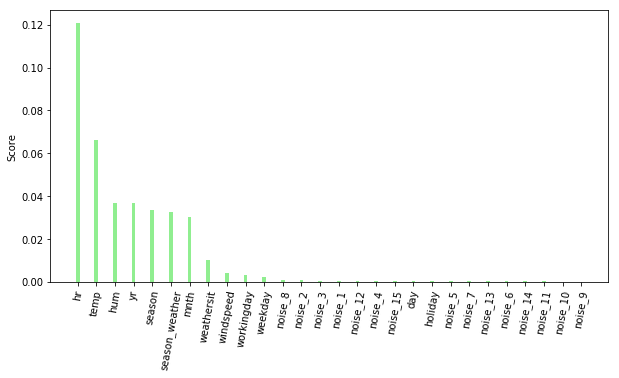

In [22]:
ranking_variables_clasificacion(X_train,y_train,nombres_atributos,"mutual_info",draw=True)

##### Comentarios

El método que hemos seleccionado para hacer el estudio de las variables que más nos aportan sobre la variable target seleccionada "cnt", es el método visto en clase llamado Mutual Information. Aún así para verificar los resultados hemos comprobado dichos resultados con los obtnidos con los scores aportados por la algoritmo "f_classif" y hemos podido comprobar como los resultados de las variables que más información aportar del target son similares.

Debido a que elegimos como target la variable "cnt", creemos que no debemos de tener en cuenta las features "casual" y "registered", ya que como vimos en la primera parte del proyecto están fuertemente correlacionadas con el target, a parte que la variable "cnt" es el resultado de la suma de estas. Y es por estos motivos son por los que hemos decidido quitarlas del cojunto de features a analizar.

Además al trabajar con la variable "cnt" como target y ser una variable contínua, la hemos discretizado y hemos creado 4 clases diferentes:

    - clase 0: (-infinito, 250]
    - clase 1: (250, 500]
    - clase 2: (500, 750]
    - clase 3: (750, +infinito]

Consecuencia de esto hemos creado una nueva variable "cnt_class", que es la que finalmente hemos seleccionado como variable target.
    
En el dataframe sobre el cual hemos trabajado, hemos definido como categórias aquellas variables o features discretas, y sobre las variables continuas hemos calculado los binsx correspondientes, dentro de la parte del código correspondinete al método de "mutual_information", a través de una fórmula basada en el número de valores de cada variable contínua.

Una vez tenemos el dataframe como queremos, seleccionadas el conjunto de variables a analizar y el target, hemos corrido los dos métodos, y como ya habíamos visto en el análsis previo durante la primera parte del proyecto, vemos como las variables que aportan más informaicón a la variable target, las que tienen más peso, son las features: 
"hr", "temp", "hum", "yr", "season", "season_weathersit", "mnth", "weathersit".



#### 2. Realizar ese mismo análisis utilizando ahora alguno de los métodos de Selección de Características por wrapping vistos en clase.
¿Obtienes lo mismo en los dos casos? En vista de los resultados obtenidos y los que obtuviste en la práctica 1:
- ¿hay alguna variable que no sea informativa?
- ¿hay alguna variable que sea informativa pero redundante?
- ¿Qué variables quitarías en vista a estos resultados de análisis
posteriores? ¿cuáles dejarías?

In [24]:
### Estrategia 3: entrenar un modelo auxiliar que esté diseñado también para dar la importancia de los atributos, 
# y seleccionar usando esta información los atributos que usaremos en nuestro modelo.

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier as kNN

aux1 = ExtraTreesClassifier(n_estimators = 21)
aux1.fit(X_train, y_train)

print(aux1.feature_importances_)

aux2 = SelectFromModel(aux1, prefit=True)
inds_elegidos = np.where(aux2.get_support())[0]
print("\nElegidos:")
print(np.array(nombres_atributos)[inds_elegidos])

X_train_red = X_train[:,inds_elegidos]
X_test_red = X_test[:,inds_elegidos]

my_model = kNN()
my_model.fit(X_train_red,y_train)

print('Score de my_model en train: %.3f' % my_model.score(X_train_red, y_train))
print('Score de my_model en test : %.3f' % my_model.score(X_test_red, y_test))

[ 0.02305893  0.04085579  0.0324828   0.16538525  0.00359696  0.02783513
  0.0243788   0.01762149  0.07991268  0.06068111  0.03094323  0.03127018
  0.02986699  0.02828967  0.02822108  0.02916385  0.02777913  0.02852727
  0.02839055  0.02977026  0.02950744  0.02875785  0.03037465  0.0288288
  0.02864251  0.02841672  0.0290409   0.02839996]

Elegidos:
['yr' 'hr' 'temp' 'hum']
Score de my_model en train: 0.855
Score de my_model en test : 0.800


##### Comentarios

¿Obtienes lo mismo en los dos casos? En vista de los resultados obtenidos y los que obtuviste en la práctica 1:

Como resultado de aplicar la estrategia 3 basada en entrenar un modelo auxiliar que esté diseñado también para dar la importancia de los atributos, y seleccionar usando esta información los atributos que usaremos en nuestro modelo, hemos obtenido el siguiente conjunto de variables: ['yr' 'mnth' 'hr' 'temp' 'hum']

Si nos fijamos con las variables de más puntuación aportadas con el algoritmo de filtrado de MI, podemos ver que las variables "hr", "temp", "hum" y "yr", eran de las que más scoring tenían por lo que parece verificar que para ambos métodos las variables seleccionadas son las que más información nos aportan sobre la variable target elegida, lo que de la misma forma se corresponde con los análisis preliminares hechos en la primera parte del proyecto, en donde claramente veíamos es esa exploración como las horas cercanas a la entrada al trabajo 7-9 y salida del mismo 8-9 había un incremento sustancial del uso del servicio de renting. 
También a partir de la variable "temp", podemos corroborar que hay una correlación entre la buena temperatura y el uso incremental del servicio de renting. También veíamos como la variable "mnth" nos aportaba información relevante respecto la variable target pues los meses cercanos a las estaciones con mejores temperaturas o periodos vacacionales había un incremento del uso de las bicicletas.


¿Hay alguna variable que no sea informativa? 

Si nos fijamos la "day", parece no ser muy informativa, al contrario de lo que analizamos nosotros en nuestro primer vistazo. Pensamos que a través de esta variable a primeros de mes cuando los usuarios pueden tener más dinero, harían menos uso del servicio de renting, y usar otros medios de transporte más caros, como el taxi, el metro o el autobús, pero vemos ahora después del estudio realizado como el score de esta variable es muy baja, y no nos aporta información sobre la varaible target, luego la podemos descartar sin ninguna duda. 

También parece que la varaible "weekday" no aporta mucha información sobre la variable target, cómo si podíamos pensar en un principio. Es decir, que el servicio de renting estuviera relacionado con el día de la semana y que el uso fuera mayor los fines de semana que entre semana, pero podemos comprobar como el score de esta varible es también baja por lo que no nos aporta información alguna. 

¿Hay alguna variable que sea informativa, pero redundante?

Entendemos que al seleccionar como target la variable “cnt”, las variables “casual” y “registered”, son redundantes, pues es la suma de ambas. Otra estrategía que podíamos haber seguido en lugar de eliminar estas en haber analizado como target los usuarios casuales y los registrados, pero nuestra intención era establecer qué varaibles nos aportaban más información para tratar de inferir en la medida de los posible bajo qué circunstacias o mejor dicho cuándo se hace un mayor uso del servicio de reting, con el fin como explicabamos anteriormente de poder mejorar el servicio, preveyendo en el futuro esos momentos de máximo uso.

¿Qué variables quitarías en vista a estos resultados de análisis posteriores? ¿cuáles dejarías?

Las variables que quitaríamos en función de la variable target seleccionada, serían aquellas que menos score nos han dado en los métodos aplicados, a saber: "day", "weekday", "workingday", "holiday", "registered" y"casual",

Por lo que dejariamos como variables para poder analizar con más profundidad:  "temp", "yr", "hum", "hr", "season", "wheathersit", "month", "windspeed".

#### 3. Visualiza la proyección de tu base de datos en los primeros componentes principales obtenidos por PCA, junto a la proyección de las variables originales (tal y como hemos visto en los ejemplos en clase). Realizaremos dos gráficos diferentes:
* Gráfico 1: Eje horizontal: proyección sobre la primera componente. Eje vertical: proyección sobre la segunda componente.
* Gráfico 2: Eje horizontal: proyección sobre la segunda componente. Eje vertical: proyección sobre la tercera componente.
¿Qué puedes decir en base a estos gráficos sobre la correlación entre las diferentes variables originales? ¿Te podría ayudar la proyección PCA para realizar una selección de variables? En caso de que sí: ¿cómo? (sólo arguméntalo). En caso de que no: ¿por qué?

In [25]:
# Lo primero que vamos a hacer es recuperar la variable registered partir de restar cnt y casual
def f(row):
    return (row['cnt']-row['casual'])

df_bike_final['registered'] = df_bike_final.apply(f, axis=1)

In [26]:
bike_data_sinNoise = df_bike_final[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 
                          'temp', 'hum', 'windspeed', 'season_weather', 'day', 'casual', 'registered']]

In [27]:
bike_data_sinNoise.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,season_weather,day,casual,registered
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,1,1,3,13
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,1,1,8,32
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,1,1,5,27
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,1,1,3,10
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,1,0,1


In [28]:
X = bike_data_sinNoise
y = df_bike_final[target_bike]
nombres_atributos = list(bike_data_sinNoise.columns)

print (nombres_atributos)

# training /test split
from sklearn.cross_validation import train_test_split
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=5)

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'season_weather', 'day', 'casual', 'registered']


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_std)

print()
print('-- Estadísticas de los datos proyectados en las componentes principales --')
print()

for i in range(X_pca.shape[1]):
    print("* Datos en componente principal", i+1, ":")
    print("  - Media    :", X_pca[:,i].mean().round(3))
    print("  - Varianza :", X_pca[:,i].var(ddof=1).round(3))
    print("  - Autovalor:", pca.explained_variance_[i].round(3))
    print("  - Varianza explicada:", (100*pca.explained_variance_ratio_[i]).round(3), "%")
    print()


-- Estadísticas de los datos proyectados en las componentes principales --

* Datos en componente principal 1 :
  - Media    : -0.0
  - Varianza : 3.058
  - Autovalor: 3.058
  - Varianza explicada: 20.383 %

* Datos en componente principal 2 :
  - Media    : -0.0
  - Varianza : 2.414
  - Autovalor: 2.414
  - Varianza explicada: 16.089 %

* Datos en componente principal 3 :
  - Media    : 0.0
  - Varianza : 1.365
  - Autovalor: 1.365
  - Varianza explicada: 9.099 %

* Datos en componente principal 4 :
  - Media    : -0.0
  - Varianza : 1.114
  - Autovalor: 1.114
  - Varianza explicada: 7.43 %

* Datos en componente principal 5 :
  - Media    : 0.0
  - Varianza : 1.078
  - Autovalor: 1.078
  - Varianza explicada: 7.188 %

* Datos en componente principal 6 :
  - Media    : -0.0
  - Varianza : 1.006
  - Autovalor: 1.006
  - Varianza explicada: 6.708 %

* Datos en componente principal 7 :
  - Media    : -0.0
  - Varianza : 1.002
  - Autovalor: 1.002
  - Varianza explicada: 6.683 %

* Datos

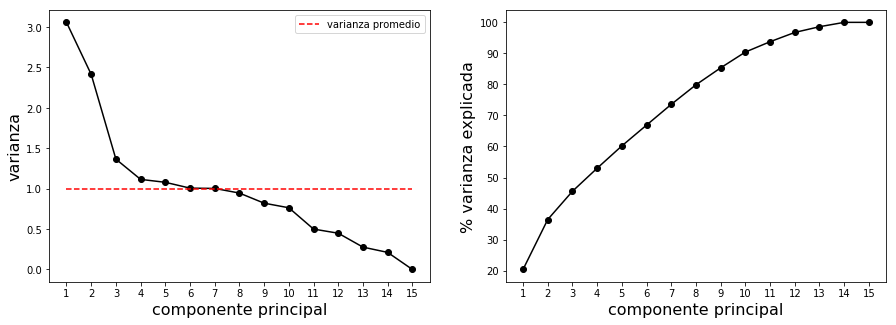

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,pca.n_components_+1), pca.explained_variance_, '-ok')
plt.plot([1,pca.n_components_], [1,1], '--r', label='varianza promedio')
plt.legend()
plt.xlabel('componente principal', fontsize=16)
plt.ylabel('varianza', fontsize=16)
plt.xticks(range(1,pca.n_components_+1))

plt.subplot(1,2,2)
plt.plot(range(1,pca.n_components_+1),
         100*pca.explained_variance_ratio_.cumsum(), '-ok')
plt.xlabel('componente principal', fontsize=16)
plt.ylabel('% varianza explicada', fontsize=16)
plt.xticks(range(1,pca.n_components_+1))
plt.show()

In [31]:
pcs_names = ['componente principal '+str(i+1) for i in range(pca.n_components_)]
pcs_names

['componente principal 1',
 'componente principal 2',
 'componente principal 3',
 'componente principal 4',
 'componente principal 5',
 'componente principal 6',
 'componente principal 7',
 'componente principal 8',
 'componente principal 9',
 'componente principal 10',
 'componente principal 11',
 'componente principal 12',
 'componente principal 13',
 'componente principal 14',
 'componente principal 15']

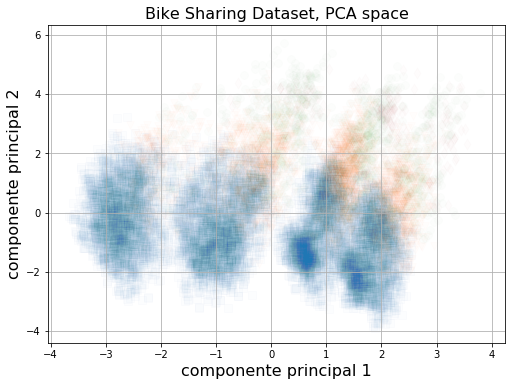

In [32]:
# componente principal 1 y componente principal 2
pc_x = 0
pc_y = 1

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(7,5))
for label,color,marker in zip(np.unique(y),colors,markers):
    inds = np.where(y == label)[0]
    plt.scatter(X_pca[inds, pc_x],
                X_pca[inds, pc_y],
                s = 60,
                c = color,
                marker = marker,
                alpha = 0.01,
                cmap='RdYlGn',
                label = label)

plt.grid(); plt.tight_layout()
plt.title('Bike Sharing Dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


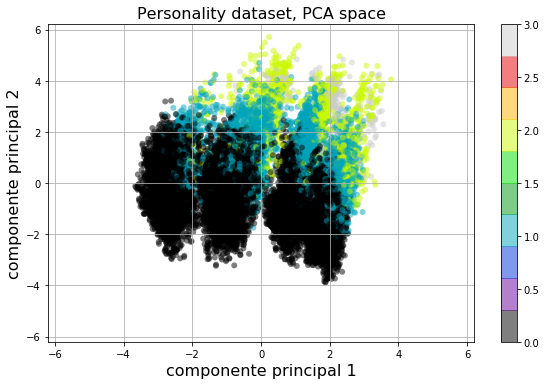

In [33]:
# componente principal 1 y componente principal 2
pc_x = 0
pc_y = 1

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca[:, pc_x], X_pca[:, pc_y],
            c=df_bike_final[target_bike], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))

plt.colorbar();
plt.grid(); plt.tight_layout()
plt.title('Personality dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

In [34]:
def PCA_plot(X_std, attribute_names, pca, pcs_names, ax, pc_x=0, pc_y=1, escala_flechas=1):
    X_pca = pca.transform(X_std)

    plt.scatter(X_pca[:, pc_x], X_pca[:, pc_y], s=20,
                c=df_bike_final[target_bike], edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('spectral', 10))

    plt.colorbar();
    
    factor = escala_flechas*6*np.sqrt(np.max(np.cov(X_std,rowvar=False)))
    aux = np.eye(len(attribute_names))
    attributes_PCA = pca.transform(aux)
    
    for a,name in zip(attributes_PCA,attribute_names):
        ax.arrow(0, 0, a[pc_x]*factor, a[pc_y]*factor,
                 head_width=1/4*0.05*factor*1.5/escala_flechas,
                 head_length=1/4*0.1*factor*1.5/escala_flechas,
                 fc='k', ec='k')
        plt.text(a[pc_x]*factor, a[pc_y]*factor, name, color='r')
        
    plt.grid(); plt.tight_layout()
    plt.xlabel(pcs_names[pc_x], fontsize=16)
    plt.ylabel(pcs_names[pc_y], fontsize=16)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


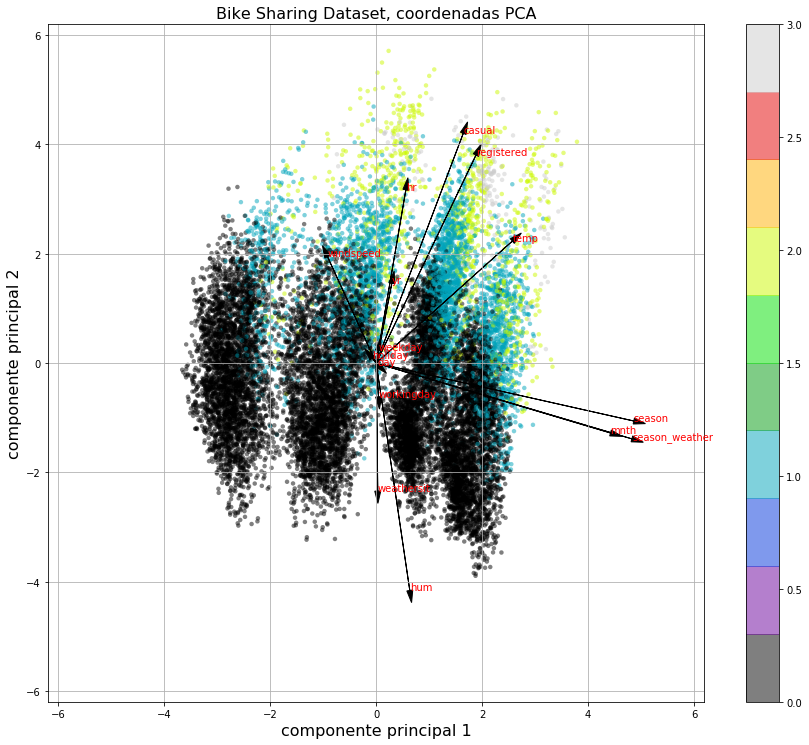

In [35]:
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(1,1,1)
PCA_plot(X_std, nombres_atributos,
         pca, pcs_names, ax, pc_x=0, pc_y=1, escala_flechas=1.5)
plt.title('Bike Sharing Dataset, coordenadas PCA', fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

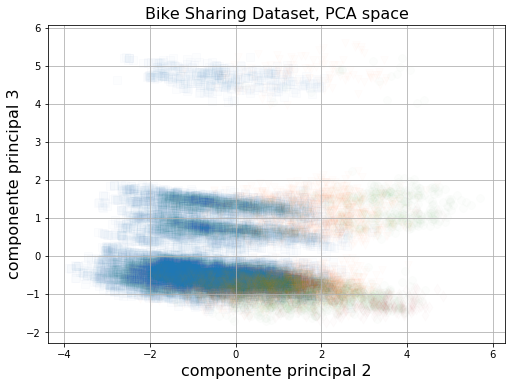

In [36]:
# componente principal 2 y componente principal 3
pc_x = 1
pc_y = 2

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(7,5))
for label,color,marker in zip(np.unique(y),colors,markers):
    inds = np.where(y == label)[0]
    plt.scatter(X_pca[inds, pc_x],
                X_pca[inds, pc_y],
                s = 60,
                c = color,
                marker = marker,
                alpha = 0.01,
                cmap='RdYlGn',
                label = label)

plt.grid(); plt.tight_layout()
plt.title('Bike Sharing Dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


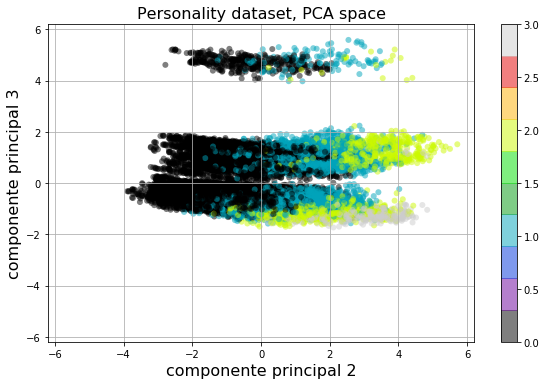

In [37]:
# componente principal 2 y componente principal 3
pc_x = 1
pc_y = 2

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca[:, pc_x], X_pca[:, pc_y],
            c=df_bike_final[target_bike], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))

plt.colorbar();
plt.grid(); plt.tight_layout()
plt.title('Personality dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


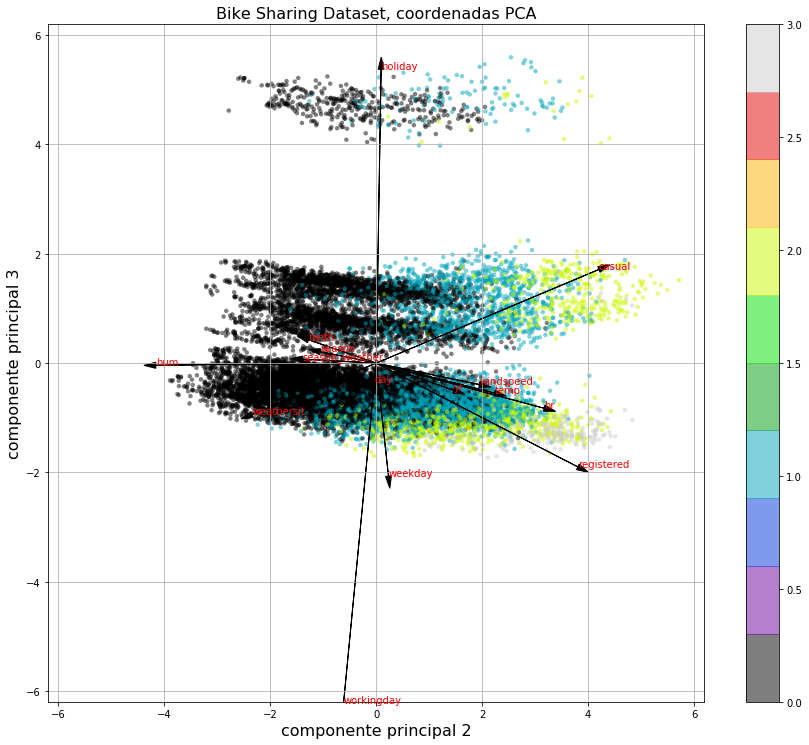

In [38]:
# componente principal 2 y componente principal 3
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(1,1,1)
PCA_plot(X_std, nombres_atributos,
         pca, pcs_names, ax, pc_x=1, pc_y=2, escala_flechas=1.5)
plt.title('Bike Sharing Dataset, coordenadas PCA', fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

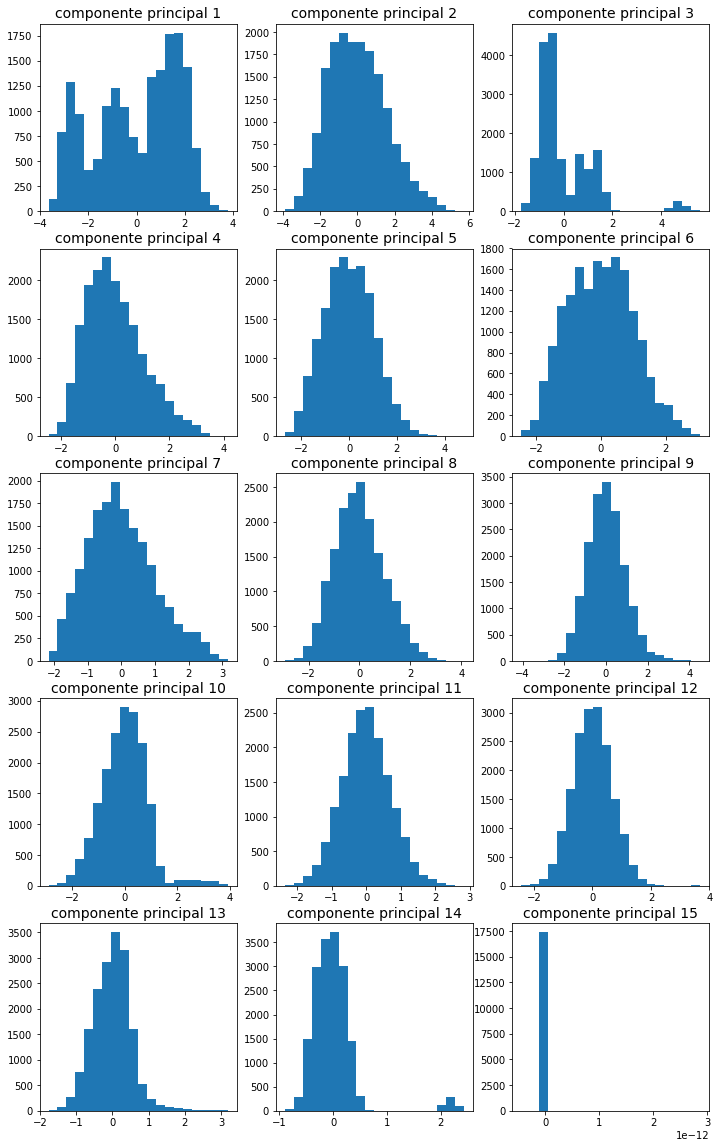

In [39]:
# histogramas de los componentes principales
nrows = int(np.ceil(pca.n_components_/3))
plt.figure(figsize=(12,4*nrows))
for i in range(pca.n_components_):
    plt.subplot(nrows,3,i+1)
    plt.hist(X_pca[:,i], bins=20)
    plt.title(pcs_names[i], fontsize=14)
plt.show()

##### Comentarios
###### PCA
Principal Component Analysis (PCA) es un método estadístico que permite simplificar la complejidad de espacios muestrales con muchas dimensiones a la vez que conserva su información. Supóngase que existe una muestra con n individuos cada uno con p variables (X1, X2, …, Xp), es decir, el espacio muestral tiene p dimensiones. PCA permite encontrar un número de factores subyacentes (z<p) que explican aproximadamente lo mismo que las p variables originales. Donde antes se necesitaban p valores para caracterizar a cada individuo, ahora bastan z valores. Cada una de estas z nuevas variables recibe el nombre de componente principal.
El método de PCA permite por lo tanto “condensar” la información aportada por múltiples variables en solo unas pocas componentes.

Una forma intuitiva de entender el proceso de PCA consiste en interpretar las componentes principales desde un punto de vista geométrico. Supóngase un conjunto de observaciones para las que se dispone de dos variables (X1, X2). El vector que define la primera componente principal (Z1) sigue la dirección en la que las observaciones varían más (linea roja). La proyección de cada observación sobre esa dirección equivale al valor de la primera componente para dicha observación (principal component scores, zi1).
La segunda componente (Z2) sigue la segunda dirección en la que los datos muestran mayor varianza y que no está correlacionada con la primera componente. La condición de no correlación entre componentes principales equivale a decir que sus direcciones son perpendiculares/ortogonales.
 
El proceso de PCA identifica aquellas direcciones en las que la varianza es mayor. 
Tanto la proporción de varianza explicada como la proporción de varianza explicada acumulada son dos valores de gran utilidad a la hora de decidir el número de componentes principales a utilizar en los análisis posteriores. Si se calculan todas las componentes principales de un set de datos, entonces, aunque transformada, se está almacenando toda la información presente en los datos originales. El sumatorio de la proporción de varianza explicada acumulada de todas las componentes es siempre 1. 

      
Se usa la proporción acumulada de varianza para determinar la cantidad total de varianza que explican los componentes principales. Se conservan los componentes principales que explican un nivel aceptable de varianza. El nivel aceptable depende de la aplicación específica. Para propósitos descriptivos, es posible que solo se necesite explicar el 80% de la varianza. Sin embargo, si se desea realizar otros análisis con los datos, se recomienda que los componentes principales expliquen por lo menos el 90% de la varianza.
Con los valores propios de la varianza también se puede determinar el número de componentes principales. Conservar los componentes principales con los valores propios más grandes. Por ejemplo, según el criterio de Kaiser, se usan solo los componentes principales con valores propios que son mayores que 1.      

Viendo los datos de las varianzas explicadas y la acumulada, y la gráfica donde se muestran, se puede observar que con los 11-12 primeros componentes principales se obtendría prácticamente toda la varianza acumulada, la totalidad de la información. Por tanto bastaría con ese número de dimensiones.
Mirando por los valores propios se aprecia como los dos primeros componentes principales tienen una mayor varianza y por lo tanto recogen mayor parte de información que el resto, y la varianza va disminuyendo en los siguientes componentes principales. Superior a 1 sólo tendrían valor propio los 7 primeros componentes principales, y el octavo prácticamente cercano a 1, así que podrían seleccionarse esos bajo otro criterio.


###### Gráficas Componente principal 1-Componente principal 2, y Componente principal 2 -Componente principal 3
En las gráficas de influencias se muestran visualmente los resultados para los dos pares de componentes, identificando con las flechas y su posición las influencias de cada atributo en relación a los componentes principales del eje x y el eje y de la gráfica.

Para el componente 1 hay bastantes variables con influencia positiva, las que más las variables de season, month y season_weather. También temp, casual y registered tienen buena influencia positiva en este componente.

En el componente 2 las variables con mayor influencia positiva son casual, registered, hr, temp y windspeed. En cuanto a influencia negativa destacan las variables de hum con la mayor influencia, y weathersit.

Por último, para el componente 3 las variables con mayor influencia positiva son holiday y casual. Y las de influencia negativa son workingday, weekday y registered. 

También se aprecia como variables que están de algún modo correlacionadas tienen casi la misma influencia para el mismo componente principal. Por ejemplo en el componente 3 que tienen una influencia más cercana las variables de holiday y casual, en contraposicion de workingday y registered, puede deberse a que en día de vacaciones es cuando más se suelen producir usos casuales, y en los días laborables la mayoría de usos son registrados.

O como variables que pueden considerarse contrarias tienen la influencia opuesta. Por ejemplo para el componente 3 la variable holiday tiene una gran influencia positiva, y la variable workingday practicamente la misma influencia pero negativa. Esto tiene lógica ya que cuando un día pertenece a una de esas categorías no pertenece a la otra.


###### ¿Te podría ayudar la proyección PCA para realizar una selección de variables? En caso de que sí: ¿cómo? (sólo arguméntalo). En caso de que no: ¿por qué?
Creemos que si sería un método que puede ayudar para la selección de las variables adecuadas sobretodo para reducir algo la dimensionalidad y poder quedarnos con un espacio más simple sin perder la información importante para analizar los datos.
En este ejemplo no se ha conseguido reducir todo lo deseado pero por los datos de varianza propia y acumulada si podría reducirse la dimensión en varios elementos.

#### 4. Implementa una función sencilla que detecte outliers usando las proyecciones PCA. Ayuda: tomando los datos de entrenamiento, calcula la proyección PCA en el número de componentes dado como argumento a la función, calcula el valor promedio de las componentes, y detecta qué puntos se alejan “demasiado” de ese promedio. Una opción sencilla es, una vez calculadas las proyecciones PCA de cada punto, calcular la distancia en ese espacio de todos los puntos al promedio, y considerar como outlier el P% de puntos que tengan distancia mayor (P estaría dado como argumento a nuestra función detectora de outliers).

In [42]:
# Para cada atributo ver los valores extremos. Se le pasa a la función el valor % para calcular los percentiles que
# delimiten los valores válidos y los outliers
from collections import defaultdict

def detectar_outliers(x, p):
    diccionario_ = {}
    atributos = x.keys()
    outlier_counts = defaultdict(lambda: 0)

    for atributo in atributos:
        values = x[atributo]
    
        # Calcular los percentiles
        P1 = np.percentile(values,p)
        P3 = np.percentile(values,100-p)
    
        # rango
        step = 1.5*(P3-P1)

        # conseguir indices de los outliers
        value_min = P1 - step
        value_max = P3 + step
        ioutliers = (values < value_min) | (values > value_max)

        # conseguir outliers
        outliers = x[ioutliers]
        diccionario_[atributo] = (value_min,value_max)
    
        # Ver los outliers detectados
        print ("Puntos considerados outliers para el atributo '{}':".format(atributo))
        display(outliers)    

        # añadir outliers al diccionario
        for i in outliers.index.values:
            outlier_counts[i] += 1
            
    return outliers

In [46]:
# llamamos a la función para detectar outliers pasando el DF y el valor para hacer los cálculos
# mostramos para cada columna del dataset los valores detectados como outliers
df_bike_final['season'] = df_bike_final.season.astype('int64')
df_bike_final['yr'] = df_bike_final.yr.astype('int64')
df_bike_final['mnth'] = df_bike_final.mnth.astype('int64')
df_bike_final['hr'] = df_bike_final.hr.astype('int64')
df_bike_final['holiday'] = df_bike_final.holiday.astype('int64')
df_bike_final['weekday'] = df_bike_final.weekday.astype('int64')
df_bike_final['workingday'] = df_bike_final.workingday.astype('int64')
df_bike_final['day'] = df_bike_final.day.astype('int64')
df_bike_final['weathersit'] = df_bike_final.weathersit.astype('int64')
df_bike_final['season_weather'] = df_bike_final.season_weather.astype('int64')

X = df_bike_final
y = df_bike_final[target_bike]
nombres_atributos = list(df_bike_final.columns)

outliers = detectar_outliers(X, 15)

Puntos considerados outliers para el atributo 'season':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'yr':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'mnth':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'hr':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'holiday':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered
372,1,0,1,0,1,1,0,2,0.20,0.47,0.2239,1,17,2,17,0,16
373,1,0,1,1,1,1,0,2,0.20,0.44,0.1940,1,16,2,17,0,15
374,1,0,1,2,1,1,0,2,0.18,0.43,0.2537,0,8,2,17,0,8
375,1,0,1,3,1,1,0,2,0.18,0.43,0.1940,0,2,2,17,0,2
376,1,0,1,4,1,1,0,2,0.18,0.43,0.1343,1,3,2,17,0,2
377,1,0,1,5,1,1,0,2,0.18,0.43,0.1642,0,1,2,17,0,1
378,1,0,1,6,1,1,0,2,0.18,0.43,0.1940,0,5,2,17,0,5
379,1,0,1,7,1,1,0,2,0.16,0.50,0.1343,4,13,2,17,0,9
380,1,0,1,8,1,1,0,2,0.16,0.47,0.2239,3,33,2,17,0,30
381,1,0,1,9,1,1,0,2,0.16,0.47,0.2239,8,47,2,17,0,39


Puntos considerados outliers para el atributo 'weekday':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'workingday':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'weathersit':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered
585,1,0,1,16,0,3,1,4,0.22,0.93,0.3284,1,36,4,26,0,35
8854,1,1,1,18,0,1,1,4,0.20,0.86,0.0896,6,164,4,9,0,158
9123,1,1,1,1,0,6,0,4,0.14,0.86,0.1940,1,23,4,21,0,22


Puntos considerados outliers para el atributo 'temp':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'hum':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'windspeed':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered
1007,1,0,2,15,0,1,1,1,0.56,0.21,0.6567,19,90,1,14,0,71
1009,1,0,2,17,0,1,1,1,0.46,0.33,0.6119,25,243,1,14,0,218
1010,1,0,2,18,0,1,1,1,0.40,0.40,0.6119,11,205,1,14,0,194
1014,1,0,2,22,0,1,1,1,0.34,0.46,0.6567,1,45,1,14,0,44
1017,1,0,2,1,0,2,1,1,0.30,0.42,0.7761,0,5,1,15,0,5
1018,1,0,2,2,0,2,1,1,0.28,0.41,0.6866,1,3,1,15,0,2
1119,1,0,2,9,0,6,0,1,0.40,0.16,0.6567,18,55,1,19,0,37
1123,1,0,2,13,0,6,0,1,0.44,0.16,0.6119,52,155,1,19,0,103
1124,1,0,2,14,0,6,0,1,0.46,0.15,0.6567,102,196,1,19,0,94
1125,1,0,2,15,0,6,0,1,0.44,0.16,0.7463,84,171,1,19,0,87


Puntos considerados outliers para el atributo 'casual':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered
2128,2,0,4,13,0,0,0,1,0.44,0.33,0.2985,219,367,5,3,1,148
2129,2,0,4,14,0,0,0,1,0.46,0.31,0.1343,240,349,5,3,1,109
2463,2,0,4,13,0,0,0,1,0.50,0.34,0.3881,181,343,5,17,1,162
2465,2,0,4,15,0,0,0,1,0.54,0.32,0.5224,179,388,5,17,1,209
2608,2,0,4,14,0,6,0,1,0.58,0.78,0.3582,182,391,5,23,1,209
2610,2,0,4,16,0,6,0,1,0.60,0.73,0.2836,180,426,5,23,1,246
2631,2,0,4,13,0,0,0,1,0.70,0.58,0.2836,205,441,5,24,1,236
2632,2,0,4,14,0,0,0,1,0.70,0.54,0.3284,197,420,5,24,1,223
2775,2,0,4,13,0,6,0,1,0.54,0.39,0.2985,185,455,5,30,1,270
2776,2,0,4,14,0,6,0,1,0.54,0.39,0.2239,184,452,5,30,1,268


Puntos considerados outliers para el atributo 'cnt':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered
10622,2,1,3,17,0,5,1,2,0.72,0.42,0.1642,264,957,6,23,3,693
14293,3,1,8,18,0,4,1,1,0.74,0.48,0.2239,130,941,9,23,3,811
14725,3,1,9,18,0,1,1,1,0.62,0.35,0.2985,111,968,9,10,3,857
14748,3,1,9,17,0,2,1,1,0.70,0.28,0.0000,168,970,9,11,3,802
14772,3,1,9,17,0,3,1,1,0.70,0.41,0.2985,114,925,9,12,3,811
14773,3,1,9,18,0,3,1,1,0.66,0.44,0.2537,91,977,9,12,3,886
14964,3,1,9,17,0,4,1,1,0.64,0.50,0.2239,91,976,9,20,3,885
15084,4,1,9,17,0,2,1,1,0.66,0.39,0.2836,107,967,13,25,3,860
15108,4,1,9,17,0,3,1,1,0.74,0.48,0.2985,77,953,13,26,3,876
15276,4,1,10,17,0,3,1,1,0.70,0.65,0.0000,84,917,13,3,3,833


Puntos considerados outliers para el atributo 'season_weather':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'day':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered


Puntos considerados outliers para el atributo 'cnt_class':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered
10406,1,1,3,17,0,3,1,1,0.70,0.28,0.0896,140,782,1,14,3,642
10527,1,1,3,18,0,1,1,1,0.64,0.57,0.2537,120,801,1,19,3,681
10550,1,1,3,17,0,2,1,1,0.60,0.73,0.1940,108,750,1,20,3,642
10551,1,1,3,18,0,2,1,1,0.60,0.69,0.2537,136,801,1,20,3,665
10575,2,1,3,18,0,3,1,1,0.60,0.69,0.0000,152,779,5,21,3,627
10598,2,1,3,17,0,4,1,1,0.66,0.65,0.1642,154,810,5,22,3,656
10599,2,1,3,18,0,4,1,1,0.66,0.65,0.1642,147,801,5,22,3,654
10622,2,1,3,17,0,5,1,2,0.72,0.42,0.1642,264,957,6,23,3,693
10623,2,1,3,18,0,5,1,1,0.70,0.45,0.1642,237,830,5,23,3,593
10885,2,1,4,17,0,2,1,1,0.62,0.17,0.1940,123,757,5,3,3,634


Puntos considerados outliers para el atributo 'registered':


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,cnt_class,registered
11581,2,1,5,18,0,3,1,1,0.56,0.73,0.2239,43,813,5,2,3,770
11916,2,1,5,17,0,3,1,1,0.72,0.51,0.1940,104,873,5,16,3,769
11917,2,1,5,18,0,3,1,1,0.72,0.51,0.2239,97,846,5,16,3,749
11940,2,1,5,17,0,4,1,1,0.66,0.31,0.1343,133,852,5,17,3,719
11941,2,1,5,18,0,4,1,1,0.66,0.27,0.1642,134,868,5,17,3,734
12060,2,1,5,17,0,2,1,1,0.72,0.54,0.0000,69,785,5,22,3,716
12061,2,1,5,18,0,2,1,1,0.68,0.61,0.1343,76,785,5,22,3,709
12252,2,1,5,17,0,3,1,1,0.74,0.48,0.0896,83,839,5,30,3,756
12253,2,1,5,18,0,3,1,1,0.74,0.48,0.1642,50,796,5,30,3,746
12276,2,1,5,17,0,4,1,1,0.76,0.31,0.1642,85,827,5,31,3,742


##### Comentarios
Se ha creado una función para calcular los posibles valores extremos para cada atributo. Se le pasa a la función el valor % para calcular los percentiles que delimiten los valores válidos y los outliers.

#### 5. Repite la visualización que realizaste en el apartado 3 marcando en colores diferentes los puntos que serían outliers y los puntos que no serían outliers (según la función que has implementado en el apartado 4). ¿Coinciden los puntos que detectas como outliers con aquellos que considerabas outliers en la práctica 1?.

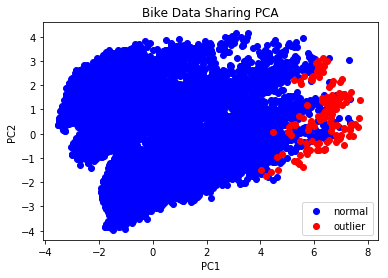

In [47]:
# pintar los outliers obtenidos para la gráfica de componente principal 1 y componente principal 2
import matplotlib.pyplot as plt
%matplotlib inline

X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_std)

abnormal_indices = list(outliers.index)
df_tmp = X.drop(labels=abnormal_indices, axis=0)
normal_indices = list(df_tmp.index)

plt.scatter(X_pca[normal_indices,0], X_pca[normal_indices,1], c= 'b', )
plt.scatter(X_pca[abnormal_indices,0], X_pca[abnormal_indices,1], c= 'r')
plt.title('Bike Data Sharing PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['normal', 'outlier'])
plt.show()

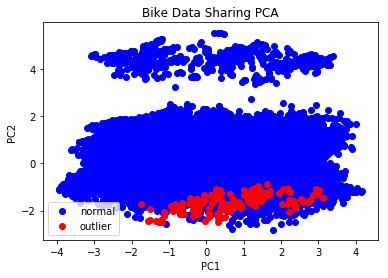

In [48]:
# pintar los outliers obtenidos para la gráfica de componente principal 2 y componente principal 3
plt.scatter(X_pca[normal_indices,1], X_pca[normal_indices,2], c= 'b', )
plt.scatter(X_pca[abnormal_indices,1], X_pca[abnormal_indices,2], c= 'r')
plt.title('Bike Data Sharing PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['normal', 'outlier'])
plt.show()

Al aplicar la función de cálculo de outliers al dataframe y obtener los registros que pueden ser considerados extremos, se procede a pintar de nuevo las dos gráficas con los primeros componentes principales, dibujando de un color distinto los registros outliers.